In [ ]:
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import string
from rake_nltk import Rake
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
book_data = pd.read_csv('/content/pages-1-100.tsv', sep='\t')

In [39]:
book_data.isnull().sum().sort_values(ascending=False)

series             4536
original_title      949
language            256
genres               92
description          64
index                 0
title                 0
authors               0
avg_rating            0
num_ratings           0
num_reviews           0
url                   0
weighted_rating       0
soup                  0
dtype: int64

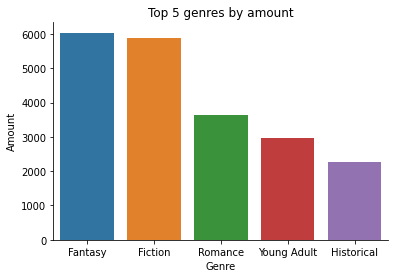

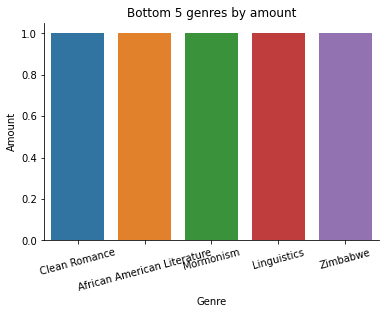

In [46]:
# Split all strings and manipulate so that we have an index per row repeated as many times as there is genres for that entry.
split_genres = book_data.loc[book_data.genres.notnull(), 'genres'].str.split(',', expand=True).stack().reset_index(level=-1, drop=True)
# Count how many entries exist per category and sort them.
split_genres_counts = split_genres.value_counts().sort_values(ascending=False)

# Plot the top 5.
sns.barplot(y=split_genres_counts[:5], x=split_genres_counts.index[:5])
sns.despine()
plt.xlabel('Genre')
plt.ylabel('Amount')
plt.title('Top 5 genres by amount')
plt.show()

# And the bottom 5.
g = sns.barplot(y=split_genres_counts[-5:], x=split_genres_counts.index[-5:])
g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='center')
sns.despine()
plt.xlabel('Genre')
plt.ylabel('Amount')
plt.title('Bottom 5 genres by amount')
plt.show()

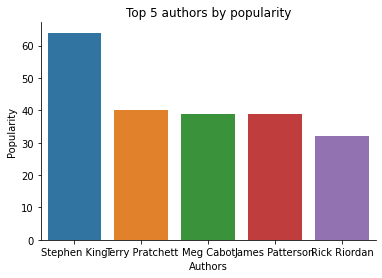

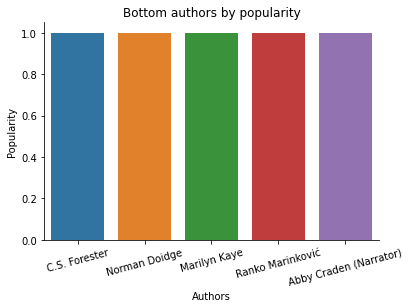

In [48]:
# Split all strings and manipulate so that we have an index per row repeated as many times as there is genres for that entry.
split_authors = book_data.loc[book_data.authors.notnull(), 'authors'].str.split(',', expand=True).stack().reset_index(level=-1, drop=True)
# Count how many entries exist per category and sort them.
split_authors_counts = split_authors.value_counts().sort_values(ascending=False)

# Plot the top 5.
sns.barplot(y=split_authors_counts[:5], x=split_authors_counts.index[:5])
sns.despine()
plt.xlabel('Authors')
plt.ylabel('Popularity')
plt.title('Top 5 authors by popularity')
plt.show()

# And the bottom 5.
g = sns.barplot(y=split_authors_counts[-5:], x=split_authors_counts.index[-5:])
g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='center')
sns.despine()
plt.xlabel('Authors')
plt.ylabel('Popularity')
plt.title('Bottom authors by popularity')
plt.show()

Removing Duplicates

In [ ]:
book_data.drop_duplicates(subset='title', inplace=True)

# Resetting the index 
book_data = book_data.reset_index()

Weighted Rating And Top Books

Weighted Rating = (v/v+m)*R+(m/v+m)*C

where

R is the average rating for the movie (mean).

v is the number of votes for the movie.

m is the minimum number of votes to be listed (25,000 in this case).

C is the mean vote across the whole report.

In [ ]:
C = book_data['avg_rating'].mean()
C

4.052728995578016

In [ ]:
m = book_data['num_ratings'].quantile(0.1)
m

2421.9000000000005

In [ ]:
def weighted_rating(book, m, C):
    # Average rating for the book.
    R = book['avg_rating']
    # Total number of votes for the book.
    v = book['num_ratings']
    # IMDB formula.
    return (v / (v+m) * R) + (m / (m+v) * C)

# Calculating the weighted rating for books that are within our threshold.
book_data.loc[book_data.num_ratings > m, 'weighted_rating'] = book_data.loc[book_data.num_ratings > m].apply(lambda x: weighted_rating(x, m, C), axis=1)

# Filling the NaN values (i.e., books lower than our threshold) with a zero score.
book_data['weighted_rating'].fillna(0, inplace=True) 

In [ ]:
book_data.sort_values('weighted_rating', ascending=False).head(5)

,index,title,original_title,series,language,authors,avg_rating,num_ratings,num_reviews,genres,description,url,weighted_rating
1525,1539,The Complete Calvin and Hobbes,The Complete Calvin and Hobbes,Calvin and Hobbes,English,Bill Watterson,4.82,33322,961,"Sequential Art,Comics,Humor,Sequential Art,Gra...",[ Box Set | Book One | Book Two | Book Three...,https://www.goodreads.com/book/show/24812.The_...,4.768012
982,988,Words of Radiance,Words of Radiance,The Stormlight Archive,English,Brandon Sanderson,4.76,172432,10541,"Fantasy,Fiction,Fantasy,Epic Fantasy,Fantasy,H...",From #1 New York Times bestselling author Bran...,https://www.goodreads.com/book/show/17332218-w...,4.750204
6306,6538,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",NaN,NaN,English,"J.K. Rowling,Mary GrandPré (Illustrator)",4.78,39132,162,"Fantasy,Young Adult,Fiction,Fantasy,Magic",Box Set containing Harry Potter and the Sorcer...,https://www.goodreads.com/book/show/8.Harry_Po...,4.737612
1469,1481,Harry Potter Series Box Set,NaN,Harry Potter,English,J.K. Rowling,4.74,234260,7065,"Fantasy,Young Adult,Fiction","Over 4000 pages of Harry Potter and his world,...",https://www.goodreads.com/book/show/862041.Har...,4.732967
5288,5455,It's a Magical World,It's a Magical World,Calvin and Hobbes,English,Bill Watterson,4.76,25119,334,"Sequential Art,Comics,Humor,Fiction,Sequential...",When cartoonist Bill Watterson announced that ...,https://www.goodreads.com/book/show/24814.It_s...,4.697804


In [ ]:
book_data.sort_values('weighted_rating', ascending=False).tail(5)

,index,title,original_title,series,language,authors,avg_rating,num_ratings,num_reviews,genres,description,url,weighted_rating
6308,6540,Awakening Inner Guru,NaN,NaN,English,"Banani Ray,Amit Ray",4.78,104,24,"Spirituality,Inspirational,Self Help",Awakening Inner Guru is a clear and straightfo...,https://www.goodreads.com/book/show/8596181-aw...,0.0
6302,6534,30 Pieces of Gold: Self Growth - How to use In...,NaN,NaN,English,"Ron Millicent,Millie Parker (Editor)",4.31,128,1,"Novels,Inspirational,Contemporary,Adult,Self H...",Inspirational Quotes – Hah - Do They Really Wo...,https://www.goodreads.com/book/show/27467291-3...,0.0
6291,6520,The Pace,The Pace,The Pace,English,Shelena Shorts,3.70,1409,258,"Young Adult,Fantasy,Romance,Fantasy,Paranormal...",Weston Wilson is not immortal and he is of thi...,https://www.goodreads.com/book/show/6599113-th...,0.0
6282,6511,A Midnight Clear,A Midnight Clear,NaN,English,William Wharton,4.18,1391,66,"Fiction,Historical,Historical Fiction,War,War,...",Set in the Ardennes Forest on Christmas Eve 19...,https://www.goodreads.com/book/show/720234.A_M...,0.0
4749,4890,Death of the Body,NaN,Crossing Death,English,Rick Chiantaretto,3.82,217,74,"Fantasy,Fantasy,Paranormal,Fantasy,Urban Fanta...",I grew up in a world of magic. By the time I w...,https://www.goodreads.com/book/show/18624197-d...,0.0


In [ ]:
# A little cleanup.
del C
del m

##Content-Based Recommender System

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Takes a string and returns an array of its processed words.
def clean_string(s):
    # Removing stopwords and punctuation.
    stop = stopwords.words('english') + list(string.punctuation)
    return [n for n in wordpunct_tokenize(s.lower()) if n not in stop]

In [ ]:
def create_soup(x):
    title_importance = 1
    language_importance = 1
    series_importance = 1
    authors_importance = 1
    genres_importance = 1

    soup = ''
    
    # Keywords from description.
    desc = x['description']
    if desc is not np.nan:
        rake = Rake()
        rake.extract_keywords_from_text(desc)
        desc_soup = ' '.join(list(rake.get_word_degrees().keys()))
        soup = ' '.join(filter(None, [soup, desc_soup]))
    
    # Title.
    title_soup = ' '.join(clean_string(x['title']) * title_importance)
    soup = ' '.join(filter(None, [soup, title_soup]))
    
    # Language.
    language = x['language']
    if language is not np.nan:
        language_soup = ' '.join(clean_string(language) * language_importance)
        soup = ' '.join(filter(None, [soup, language_soup]))
    
    # Series.
    series = x['series']
    if series is not np.nan:
        series_soup = ' '.join(clean_string(series) * series_importance)
        soup = ' '.join(filter(None, [soup, series_soup]))

    # Authors.
    authors = x['authors']
    if authors is not np.nan:
        # I'm trying to not remove punctuation here but to just set all as spaces. I want to retain (Role).
        # Providing it's consistent across entries, this should work.
        author_soup = ' '.join([a.lower().replace(' ', '') for a in authors.split(',')] * authors_importance)
        soup = ' '.join(filter(None, [soup, author_soup]))
    
    # Genres.
    genres = x['genres']
    if genres is not np.nan:
        # Almost the same treatment as authors (strip spaces to make matching a bit more likely).
        genre_soup = ' '.join([g.lower().replace(' ', '') for g in genres.split(',')] * genres_importance)
        soup = ' '.join(filter(None, [soup, genre_soup]))
    
    return soup

In [ ]:
book_data['soup'] = book_data.apply(create_soup, axis=1)

In [ ]:
book_data.soup.head()

0    procession crosses chaucer pages full life ric...
1    1979 tim brien going cacciato — novel vietnam ...
2    postmodern visionary also master styles genres...
3    suspenseful outlandish absorbing fun novel unl...
4    winner national book award fictionnominated cr...
Name: soup, dtype: object

Creating the similarity matrix between all books based on our soup.

In [ ]:
count_vec = CountVectorizer()
count_matrix = count_vec.fit_transform(book_data['soup'])

from sklearn.metrics.pairwise import linear_kernel
cos_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
cos_sim

array([[1.        , 0.17464561, 0.11426651, ..., 0.10249001, 0.0522055 ,
        0.0208935 ],
       [0.17464561, 1.        , 0.11973687, ..., 0.07607258, 0.07749843,
        0.01550807],
       [0.11426651, 0.11973687, 1.        , ..., 0.05738476, 0.10439346,
        0.01671199],
       ...,
       [0.10249001, 0.07607258, 0.05738476, ..., 1.        , 0.05305954,
        0.17837652],
       [0.0522055 , 0.07749843, 0.10439346, ..., 0.05305954, 1.        ,
        0.08653327],
       [0.0208935 , 0.01550807, 0.01671199, ..., 0.17837652, 0.08653327,
        1.        ]])

In [ ]:
# Reverse lookup of title vs. index.
title_to_index = pd.Series(book_data.index, index=book_data['title'])

In [ ]:
def get_recommendation(title):
    idx = title_to_index[title]
    #     print(idx)
    #     print(book_data.loc[idx].soup)
    
    scores = pd.Series(cos_sim[idx]).sort_values(ascending=False)
    book_indices = list(scores.iloc[1:6].index)
    
    #     scores = list(enumerate(cos_sim[idx]))
    #     scores = sorted(scores, key=lambda x: x[1], reverse=True)
    #     scores = scores[1:11]
    #     book_indices = [i[0] for i in scores]
    #     print(scores[1:11])
    return book_data.iloc[book_indices]

get_recommendation("The Hitchhiker's Guide to the Galaxy")

,index,title,original_title,series,language,authors,avg_rating,num_ratings,num_reviews,genres,description,url,weighted_rating,soup
929,934,The Restaurant at the End of the Universe,The Restaurant at the End of the Universe,Hitchhiker's Guide to the Galaxy,English,Douglas Adams,4.22,210747,5133,"Science Fiction,Fiction,Humor,Fantasy,Humor,Co...",Alternate Cover Edition ISBN 0345418921 (ISBN1...,https://www.goodreads.com/book/show/8695.The_R...,4.218100,alternate cover edition isbn 0345418921 isbn13...
1623,1638,The Ultimate Hitchhiker's Guide to the Galaxy,The Ultimate Hitchhiker's Guide: Five Complete...,Hitchhiker's Guide to the Galaxy,English,Douglas Adams,4.38,265641,4980,"Science Fiction,Fiction,Humor,Fantasy,Classics","At last in paperback in one complete volume, h...",https://www.goodreads.com/book/show/13.The_Ult...,4.377043,last paperback one complete volume five novels...
3569,3657,The Hitchhiker's Guide to the Galaxy: A Trilog...,The Hitchhiker's Guide to the Galaxy: The Tril...,Hitchhiker's Guide to the Galaxy,English,Douglas Adams,4.51,33696,523,"Science Fiction,Fiction,Humor,Fantasy",Charting the whole of Arthur Dent's odyssey th...,https://www.goodreads.com/book/show/841628.The...,4.479338,charting whole arthur dent odyssey space hitch...
2871,2922,Mostly Harmless,Mostly Harmless,Hitchhiker's Guide to the Galaxy,English,Douglas Adams,3.97,99423,2318,"Science Fiction,Fiction,Humor,Fantasy,Humor,Co...",It’s easy to get disheartened when your planet...,https://www.goodreads.com/book/show/360.Mostly...,3.971967,’ easy get disheartened planet blown woman lov...
814,817,"Life, the Universe and Everything","Life, the Universe and Everything",Hitchhiker's Guide to the Galaxy,English,Douglas Adams,4.20,182318,3099,"Science Fiction,Fiction,Humor,Fantasy",The unhappy inhabitants of planet Krikkit are ...,https://www.goodreads.com/book/show/8694.Life_...,4.198069,unhappy inhabitants planet krikkit sick lookin...


In [ ]:
import pickle

In [ ]:
pickle.dump(book_data.to_dict(),open("books.pkl","wb"))

In [ ]:
pickle.dump(cos_sim,open("similarity2.pkl","wb"))